In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

F

<module 'pyspark.sql.functions' from '/opt/conda/lib/python3.8/site-packages/pyspark/sql/functions.py'>

In [3]:
try:
    spark.stop()
except:
    pass

try:
    sc.stop()
except:
    pass

In [5]:
## так как я взял инфру из первого дз, спарк там запущен в докер контейнере и к нему присосаны два слейва - его 2 ноды воркеров
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .config("spark.sql.adaptive.enabled", False) \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.sql.sources.bucketing.enabled", True) \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "2g") \
    .appName("hw1") \
    .getOrCreate()
    # .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \

- Параметры по памяти определить самостоятельно
- Включение AQE или Auto Broadcast => не зачет

# Задание 1

В исходном файле представлена информация о сотрудниках, их подразделении и заработной плате.
1. Использовать Spark-сессию, которую мы использовали на семинарах или в ДЗ №1
2. Посчитать среднюю зарплату в каждом подразделении с применением Spark RDD
3. При решении задачи необходимо использовать функцию `aggregateByKey`

In [4]:
spark

sc = spark.sparkContext

### Решение

In [13]:
# читаем employees.csv из смаунченной /data
rdd = sc.textFile('file:///data/task1/employees.csv')
rdd.take(5)

['1,Козлов Алексей,Design,121846',
 '2,Иванов Дмитрий,Operations,89891',
 '3,Васильев Роман,Sales,120380',
 '4,Александров Андрей,Security,178169',
 '5,Лебедев Дмитрий,Admin,61106']

In [24]:

# 3. парсим строку в (department, salary)
def parse_line(line: str):
    parts = line.split(",")
    # ожидаем ровно 4 поля: id, ФИО, департамент, зарплата
    dept = parts[2].strip()
    salary = int(parts[3].strip())   # ВАЖНО: квадратные скобки!
    return (dept, salary)

dept_salary_rdd = rdd.map(parse_line)

dept_salary_rdd.take(5)

[('Design', 121846),
 ('Operations', 89891),
 ('Sales', 120380),
 ('Security', 178169),
 ('Admin', 61106)]

In [29]:
zero_value = (0, 0)


## reduce внутри партиции, acc - сюда считаем N зарплат внутри партиции и делаем count + 1, salary - новое значение 
def seq_op(acc, salary):
    s, c = acc
    return (s + salary, c + 1)


## с разных партиций собираем данные
def comb_op(acc1, acc2):
    s1, c1 = acc1
    s2, c2 = acc2
    return (s1 + s2, c1 + c2)

sum_count_by_dept = dept_salary_rdd.aggregateByKey(
    zero_value,
    seq_op,
    comb_op
)  


avg_salary_by_dept = sum_count_by_dept.mapValues(
    lambda sc_pair: sc_pair[0] / sc_pair[1]  # sum / count
)


avg_salary_by_dept.collect()

[('Design', 128973.73214285714),
 ('Sales', 120917.60869565218),
 ('Security', 123997.92537313433),
 ('Admin', 127531.125),
 ('R&D', 119201.8),
 ('Product', 128217.5076923077),
 ('Legal', 125467.89333333333),
 ('Finance', 128928.08474576271),
 ('QA', 117809.54838709677),
 ('Support', 120634.5375),
 ('IT', 124254.38888888889),
 ('Marketing', 130941.44155844155),
 ('Operations', 125065.85483870968),
 ('HR', 125414.59154929577),
 ('Logistics', 122105.28301886792)]

# Задание 2

## Входные данные

Таблица `transactions` - информация о длительности просмотра контента пользователями:
1. user_uid — уникальный идентификатор пользователя
2. element_uid — уникальный идентификатор контента
3. watched_time — время просмотра в секундах

Справочник `catalogue` - каталог с описанием контента и метаинформации по нему

P.S. Как вы можете заметить при просмотре данных по пользователями, нужный нам ключ для операции будет перекошен (90% строк представлены на фильм, очень популярный среди смотревших) - это нужно доказать, то есть описать проблему в датасетах с точки зрения обработки Spark

### Решение

In [8]:
transactions = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("file:///data/task2/skew_transactions.csv")

transactions.show(5)
transactions.printSchema()

+--------+-----------+------------+
|user_uid|element_uid|watched_time|
+--------+-----------+------------+
|  408794|       2714|        7583|
|  247546|       2714|        4450|
|   43556|       2714|        7569|
|  517299|       2714|           1|
|  143593|       2714|        7284|
+--------+-----------+------------+
only showing top 5 rows

root
 |-- user_uid: integer (nullable = true)
 |-- element_uid: integer (nullable = true)
 |-- watched_time: integer (nullable = true)



Показываем явный перекос, ключ 2714 встречается очень много раз
ну ещё можно догадаться какую оптимизацию нужно использовать из этой строки     .config("spark.sql.autoBroadcastJoinThreshold", -1) \

In [ ]:
transactions.groupBy("element_uid").count().orderBy(F.desc("count")).show(10)

+-----------+--------+
|element_uid|   count|
+-----------+--------+
|       2714|20496000|
|        747|   61272|
|       2639|   61119|
|       3783|   55228|
|       2245|   52942|
|       6127|   52168|
|      10061|   48993|
|       3916|   48243|
|       8771|   47480|
|       3336|   45646|
+-----------+--------+
only showing top 10 rows



In [16]:
import json
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, StringType, ArrayType, DoubleType
)

# 1. Читаем JSON в Python (он небольшой, 2.8 МБ)
with open("/data/task2/catalogue.json", "r") as f:
    raw = json.load(f)   # dict: {"1983": {...}, "3783": {...}, ...}

# 2. Готовим строки с ОДНОЗНАЧНЫМИ типами
rows = []
for element_id_str, payload in raw.items():
    # ключ — это element_uid
    element_id = int(element_id_str)

    # защитно достаём значения, приводим к нужным типам
    t = payload.get("type")

    availability = payload.get("availability")
    if availability is not None:
        availability = [str(x) for x in availability]

    duration = payload.get("duration")
    duration = int(duration) if duration is not None else None

    def as_float(name):
        val = payload.get(name)
        return float(val) if val is not None else None

    feature_1 = as_float("feature_1")
    feature_2 = as_float("feature_2")
    feature_3 = as_float("feature_3")
    feature_4 = as_float("feature_4")
    feature_5 = as_float("feature_5")

    attributes = payload.get("attributes")
    if attributes is not None:
        attributes = [int(x) for x in attributes]

    row = {
        "element_uid": element_id,
        "type": t,
        "availability": availability,
        "duration": duration,
        "feature_1": feature_1,
        "feature_2": feature_2,
        "feature_3": feature_3,
        "feature_4": feature_4,
        "feature_5": feature_5,
        "attributes": attributes,
    }
    rows.append(row)

# 3. Явная схема
schema = StructType([
    StructField("element_uid", IntegerType(), False),
    StructField("type", StringType(), True),
    StructField("availability", ArrayType(StringType()), True),
    StructField("duration", IntegerType(), True),
    StructField("feature_1", DoubleType(), True),
    StructField("feature_2", DoubleType(), True),
    StructField("feature_3", DoubleType(), True),
    StructField("feature_4", DoubleType(), True),
    StructField("feature_5", DoubleType(), True),
    StructField("attributes", ArrayType(IntegerType()), True),
])

# 4. Создаём DataFrame с заданной схемой
catalogue = spark.createDataFrame(rows, schema=schema)

catalogue.printSchema()
catalogue.show(5, truncate=False)


root
 |-- element_uid: integer (nullable = false)
 |-- type: string (nullable = true)
 |-- availability: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- duration: integer (nullable = true)
 |-- feature_1: double (nullable = true)
 |-- feature_2: double (nullable = true)
 |-- feature_3: double (nullable = true)
 |-- feature_4: double (nullable = true)
 |-- feature_5: double (nullable = true)
 |-- attributes: array (nullable = true)
 |    |-- element: integer (containsNull = true)

+-----------+-----+------------------------------+--------+--------------------+------------+---------+------------+------------+-------------------------------------------------------------------------------------------+
|element_uid|type |availability                  |duration|feature_1           |feature_2   |feature_3|feature_4   |feature_5   |attributes                                                                                 |
+-----------+-----+-----------------------

In [18]:
# Здесь необходимо вывести результат:
# базовый join
joined_plain = (
    transactions.alias("t")
    .join(catalogue.alias("c"), on="element_uid", how="left")
)

joined_plain.show(50, truncate=False)

+-----------+--------+------------+------+------------------------------+--------+--------------------+------------+---------+------------+------------+---------------------------------------------------------------------------------------------------------------------------------------+
|element_uid|user_uid|watched_time|type  |availability                  |duration|feature_1           |feature_2   |feature_3|feature_4   |feature_5   |attributes                                                                                                                             |
+-----------+--------+------------+------+------------------------------+--------+--------------------+------------+---------+------------+------------+---------------------------------------------------------------------------------------------------------------------------------------+
|4101       |234775  |4506        |movie |[purchase, rent, subscription]|80      |3.7477159218975045E7|0.6773504396|16.0     |1.13860

### Решение с оптимизацией

In [ ]:
# Ваше решение в ячейках ниже ...

# оптимизированный join с broadcast
joined_optimized = (
    transactions.alias("t")
    .join(F.broadcast(catalogue).alias("c"), on="element_uid", how="left")
)

joined_optimized.explain()
joined_optimized.show(truncate=False)

== Physical Plan ==
*(2) Project [element_uid#92, user_uid#91, watched_time#93, type#329, availability#330, duration#331, feature_1#332, feature_2#333, feature_3#334, feature_4#335, feature_5#336, attributes#337]
+- *(2) BroadcastHashJoin [element_uid#92], [element_uid#328], LeftOuter, BuildRight, false
   :- FileScan csv [user_uid#91,element_uid#92,watched_time#93] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/data/task2/skew_transactions.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_uid:int,element_uid:int,watched_time:int>
   +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, false] as bigint)),false), [plan_id=323]
      +- *(1) Scan ExistingRDD[element_uid#328,type#329,availability#330,duration#331,feature_1#332,feature_2#333,feature_3#334,feature_4#335,feature_5#336,attributes#337]


+-----------+--------+------------+-----+------------------------------+--------+--------------------+-------

# Задание 3

## Входные данные

Таблица `transactions`  — информация о длительности просомтра контента пользователями:

1. user_uid — уникальный идентификатор пользователя
2. element_uid — уникальный идентификатор контента
3. watched_time — время просмотра в секундах

Таблица `ratings`  — информация об оценках, поставленных пользователями:

1. user_uid — уникальный идентификатор пользователя
2. element_uid — уникальный идентификатор контента
3. rating — поставленный пользователем рейтинг

Справочник `user_uids`  — выборка пользователей:
1. user_uid — уникальный идентификатор пользователя


## Что нужно сделать
Для каждого пользователя из выборки посчитать:
1. Максимальное и минимальное время просмотра фильмов с оценками 8, 9 и 10
2. Название фичи должно быть в формате `feat_<агрегирующая_функция>_watched_time_rating_<оценка>`
3. Если у пользователь не ставил оценки 8, 9 и 10 то значение фичей должно быть null
4. Описать принятые при разработки кода решения и возможные оптимизации

Важно: сокращаем затраты на shuflle

## Перед выполнением всех join-ов, мы фильтруем оценки + делаем pivot для таблицы с оценкам

In [24]:
from pyspark.sql import functions as F

transactions = (
    spark.read
    .option("header", True)
    .csv("file:///data/task3/cut_transactions.csv")
    .select(
        F.col("user_uid").cast("long"),
        F.col("element_uid").cast("long"),
        F.col("watched_time").cast("long"),
    )
)

ratings = (
    spark.read
    .option("header", True)
    .csv("file:///data/task3/cut_ratings.csv")
    .select(
        F.col("user_uid").cast("long"),
        F.col("element_uid").cast("long"),
        F.col("rating").cast("int"),
    )
)

user_ids = (
    spark.read
    .option("header", True)
    .csv("file:///data/task3/ids.csv")
    .select(F.col("user_uid").cast("long"))
)

transactions.show(5)
ratings.show(5)
user_ids.show(5)


+--------+-----------+------------+
|user_uid|element_uid|watched_time|
+--------+-----------+------------+
|  563180|       6130|        3264|
|  133315|       2771|       10557|
|  290104|        984|        6845|
|  385385|       6980|        2734|
|  408794|       2714|        7583|
+--------+-----------+------------+
only showing top 5 rows

+--------+-----------+------+
|user_uid|element_uid|rating|
+--------+-----------+------+
|  571252|       1364|    10|
|   63140|       3037|    10|
|  443817|       4363|     8|
|  359870|       1364|    10|
|  359870|       3578|     9|
+--------+-----------+------+
only showing top 5 rows

+--------+
|user_uid|
+--------+
|  110138|
|  412991|
|   83691|
|  334052|
|   24124|
+--------+
only showing top 5 rows



### Решение

In [ ]:
# Ваше решение в ячейках ниже ...

In [ ]:
good_ratings = ratings.filter(F.col("rating").isin([8, 9, 10])) ## фильтрация оценок с 7 < x <= 10

In [27]:
joined = transactions.join(
    F.broadcast(good_ratings),
    on=["user_uid", "element_uid"],
    how="inner"
)

joined.show(5)

+--------+-----------+------------+------+
|user_uid|element_uid|watched_time|rating|
+--------+-----------+------------+------+
|   61690|       1415|        7289|     8|
|  566386|        747|       10979|     9|
|  153993|       1912|        6942|    10|
|  336070|       7987|        5434|     8|
|  485006|       7789|        7097|     9|
+--------+-----------+------------+------+
only showing top 5 rows



In [33]:
pivoted = (
    joined
        .groupBy("user_uid")
        .pivot("rating", [8, 9, 10])
        .agg(
            F.max("watched_time").alias("max_time"),
            F.min("watched_time").alias("min_time")
        )
)

pivoted.show(50)

+--------+----------+----------+----------+----------+-----------+-----------+
|user_uid|8_max_time|8_min_time|9_max_time|9_min_time|10_max_time|10_min_time|
+--------+----------+----------+----------+----------+-----------+-----------+
|  459856|      NULL|      NULL|      NULL|      NULL|       7799|       7799|
|   40132|      NULL|      NULL|      NULL|      NULL|       7566|       7566|
|  393270|      NULL|      NULL|     15287|     15287|       NULL|       NULL|
|  116139|      NULL|      NULL|      NULL|      NULL|      32916|      32916|
|  255354|      NULL|      NULL|      NULL|      NULL|        184|        184|
|  426340|      NULL|      NULL|      NULL|      NULL|      15819|      15819|
|  470763|      NULL|      NULL|      NULL|      NULL|       6868|       6868|
|  217853|      NULL|      NULL|      NULL|      NULL|       7682|       7682|
|  179448|      NULL|      NULL|      NULL|      NULL|       7902|       7902|
|  196029|      NULL|      NULL|      NULL|      NUL

In [34]:
final = user_ids.join(pivoted, on="user_uid", how="left")

final.show(truncate=False)

+--------+----------+----------+----------+----------+-----------+-----------+
|user_uid|8_max_time|8_min_time|9_max_time|9_min_time|10_max_time|10_min_time|
+--------+----------+----------+----------+----------+-----------+-----------+
|124821  |NULL      |NULL      |NULL      |NULL      |7271       |121        |
|537222  |15013     |15013     |NULL      |NULL      |NULL       |NULL       |
|107891  |5550      |93        |NULL      |NULL      |NULL       |NULL       |
|571326  |NULL      |NULL      |NULL      |NULL      |NULL       |NULL       |
|412991  |NULL      |NULL      |NULL      |NULL      |NULL       |NULL       |
|110138  |11682     |11682     |5160      |5160      |8599       |4569       |
|278352  |NULL      |NULL      |NULL      |NULL      |NULL       |NULL       |
|24124   |16        |16        |2578      |1575      |NULL       |NULL       |
|513130  |NULL      |NULL      |NULL      |NULL      |NULL       |NULL       |
|97634   |6504      |6504      |NULL      |NULL     

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 42684)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.8/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.8/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/conda/lib/python3.8/site-packages/pyspark/accumulators.py", line 271, in accum_updates
    num_up

# Задание 4

## Входные данные

1. Потоковые данные о транзакциях из Kafka
2. Ивенты генерятся случайным образом, при помощи скрипта в директории task5/ или task4/ - они дублируются и структура одинаковая

Важно: данные генерируются случайным образом, поэтому результат будет у всех разный, соответственно можно ловить в том числе простые анамалии, например, статистически значимое отклонение значения какого-либо атрибута

## Что нужно сделать

1. Обработать потоковые данные: чтение и обработка данных о транзакциях в реальном времени, преобразовать входящие данные в DataFrame
2. Вычислить скользящее среднее значение суммы транзакций за последние 5 минут
3. Определить аномалии: пометить проблемные транзакции, например, если значение суммы транзакции больше среднего значения суммы транзакций в 2 раза
4. Вывести данные об аномальных транзакциях в консоль в режиме реального времени


### Джарника кафки не было изначально в спарке, пришлось писать доп. аргументы при запуске спарка:
#### PYSPARK_SUBMIT_ARGS: "--master spark://spark-master:7077 --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3 pyspark-shell"
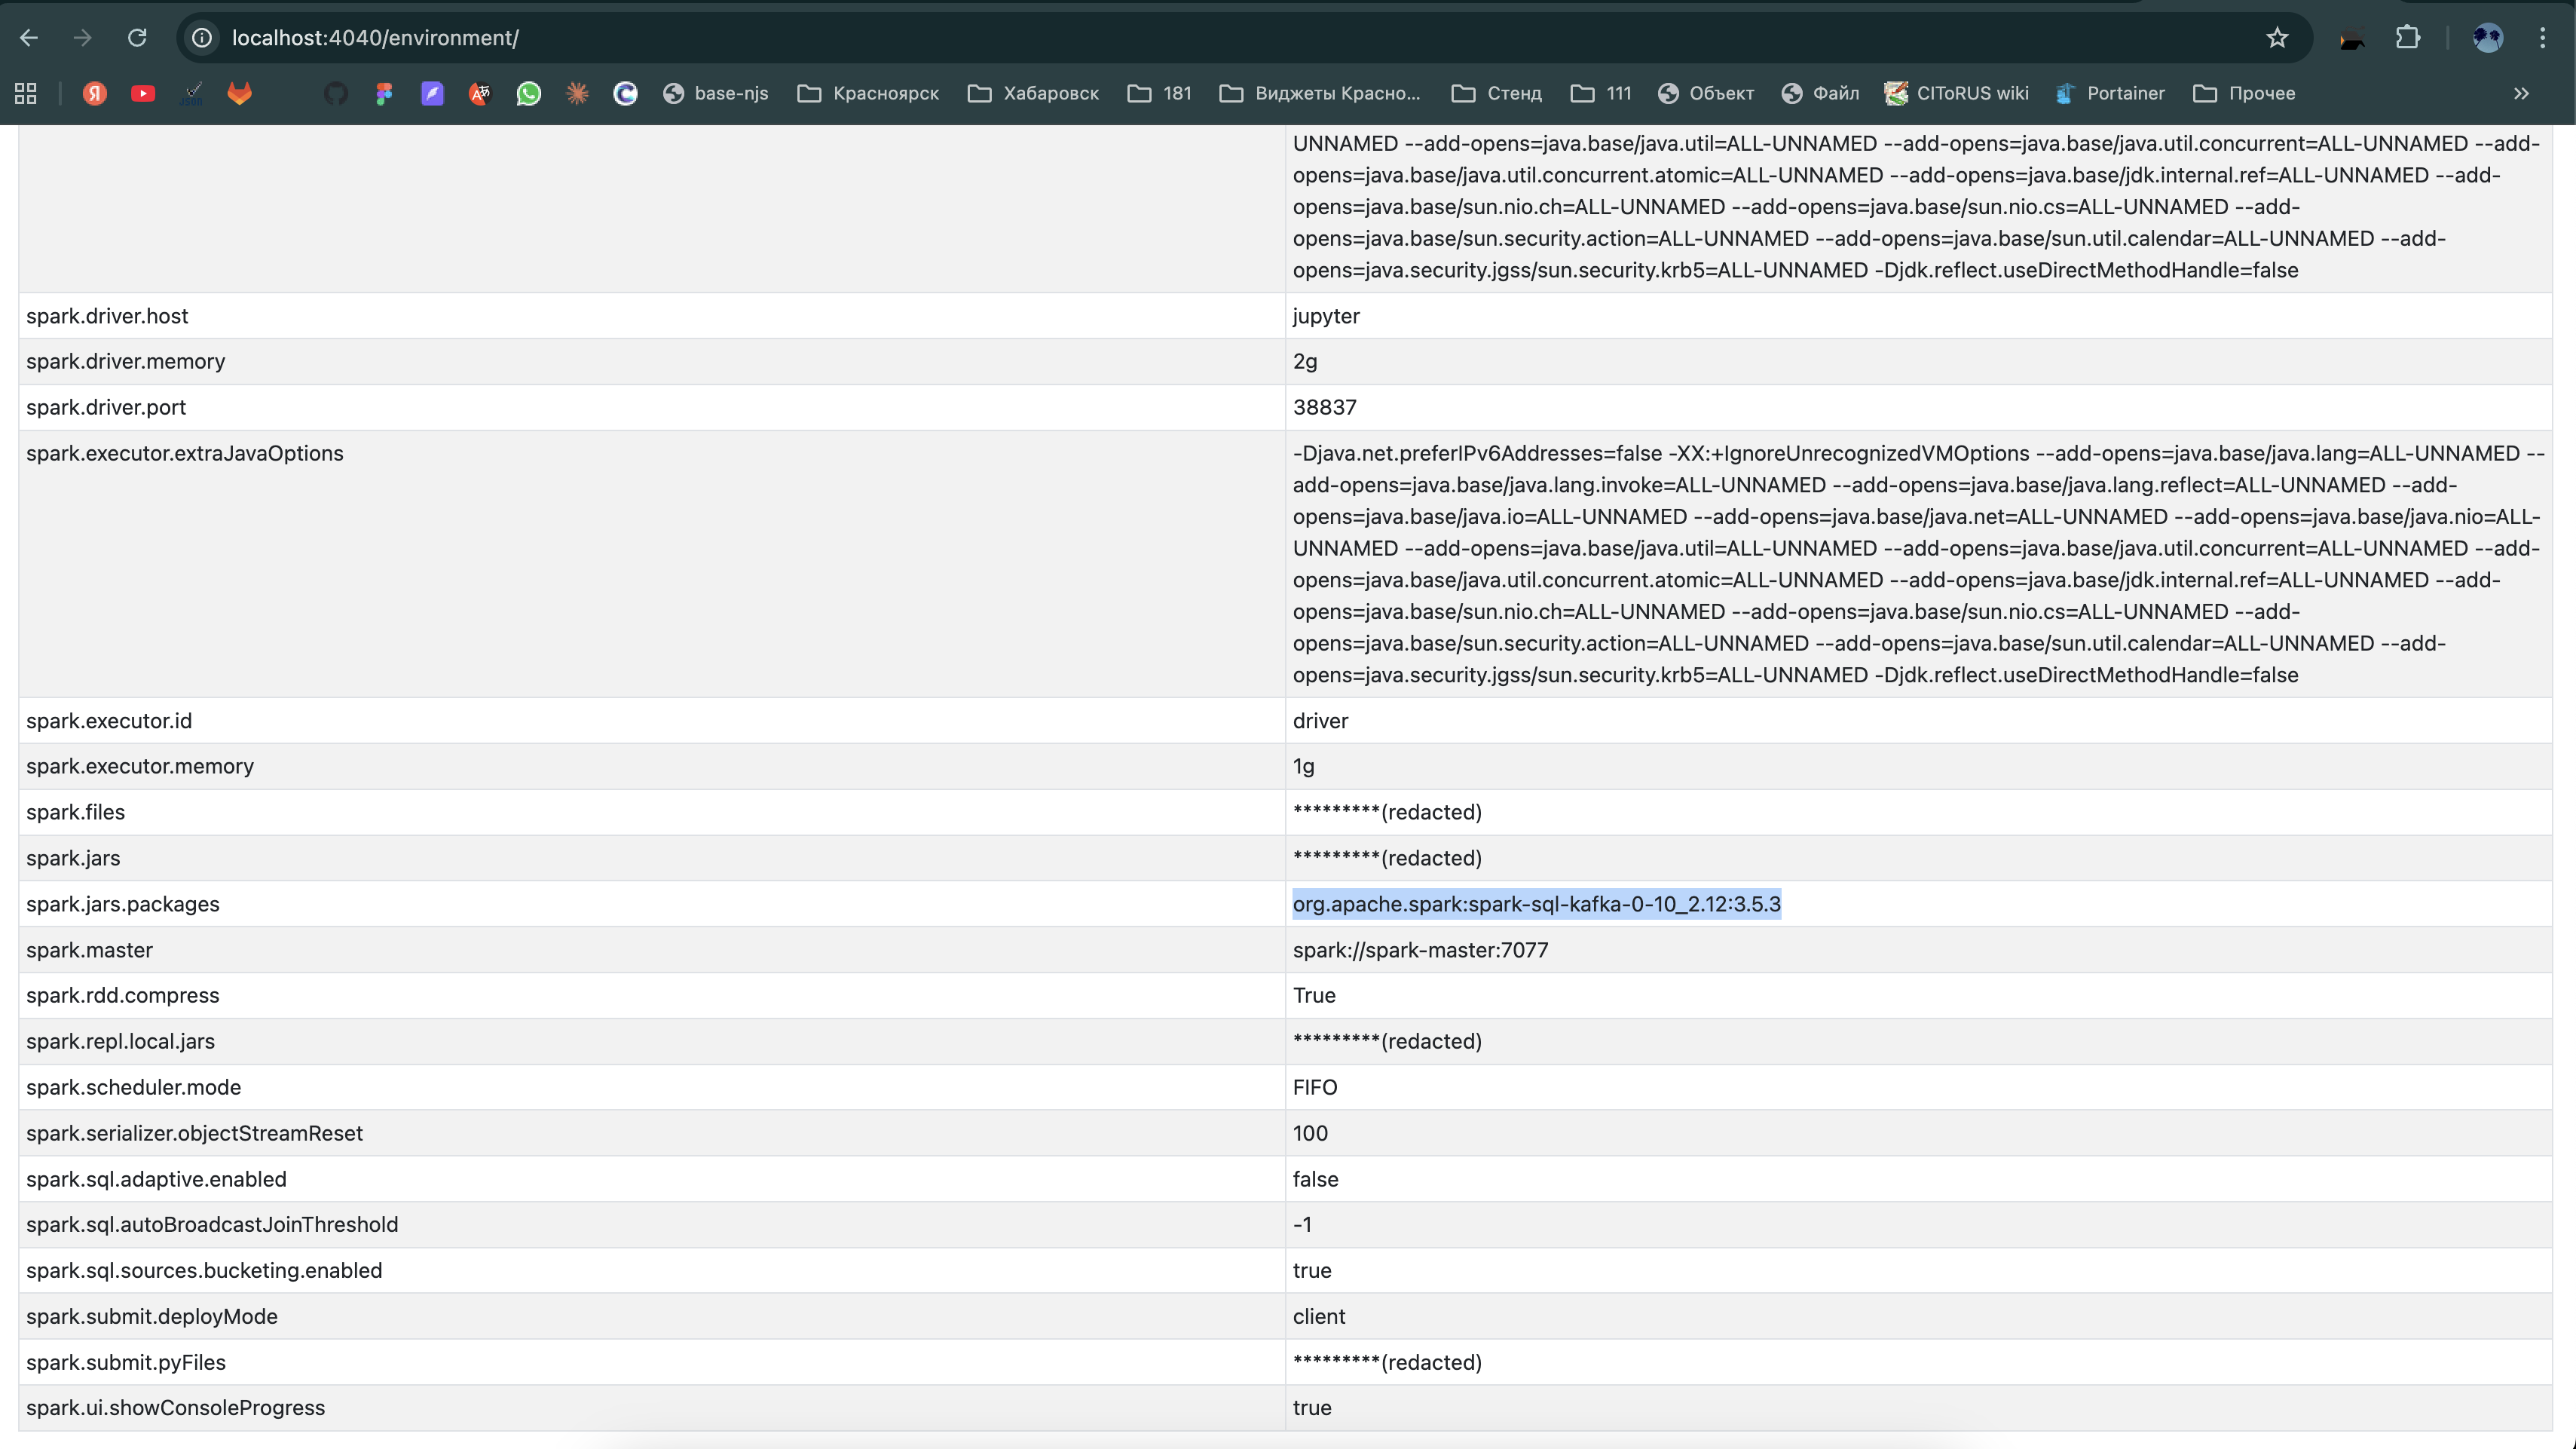

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

F

<module 'pyspark.sql.functions' from '/opt/conda/lib/python3.8/site-packages/pyspark/sql/functions.py'>

In [49]:
for q in spark.streams.active:
    print("Stopping:", q.name, q.id)
    q.stop()


Stopping: None be11c834-2955-4bc2-b8b0-e8dfde671bb1
Stopping: None 1faa6dbd-41d8-4984-ae25-76a697a392db
Stopping: None 9c755598-9b7b-4782-8d01-552bb294b60a
Stopping: None 1202c936-d5e2-4baf-aad5-243cb3fc9823
Stopping: None b967eede-3e8c-4e39-abeb-f29c2cf1ae40


In [61]:
spark.streams.active

[]

In [36]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .config("spark.sql.adaptive.enabled", False) \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.sql.sources.bucketing.enabled", True) \
    .config("spark.executor.memory", "1g") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .config("spark.driver.memory", "2g") \
    .appName("hw1") \
    .getOrCreate()

In [35]:
spark.stop()

Читаем стрим из кафки с отдельного топика - transactions_stream и суём в датафрейм

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import (
    StructType, StructField,
    StringType, DoubleType, LongType
)

event_schema = StructType([
    StructField("transaction_id", StringType()),
    StructField("user_id", LongType()),
    StructField("timestamp", StringType()),   # ISO-строка, ниже приведём к TimestampType
    StructField("amount", DoubleType()),
    StructField("currency", StringType()),
    StructField("transaction_type", StringType()),
    StructField("status", StringType()),
])

kafka_stream = (
    spark.readStream
         .format("kafka")
         .option("kafka.bootstrap.servers", "kafka:29092")
         .option("subscribe", "transactions_stream")
         .option("startingOffsets", "earliest")
         .load()
)

parsed_stream = (
    kafka_stream
    .select(F.col("value").cast("string").alias("json_str"))
    .select(F.from_json("json_str", event_schema).alias("data"))
    .select("data.*")
)

# 1.4. Приводим timestamp к типу TimestampType
events = parsed_stream.withColumn(
    "event_time",
    F.to_timestamp("timestamp")
).drop("timestamp")

events.printSchema()


root
 |-- transaction_id: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- event_time: timestamp (nullable = true)



## скользящее среднее суммы

In [55]:
from pyspark.sql.functions import window, avg, col

events_wm = events.withWatermark("event_time", "10 minutes")

windowed_avg = (
    events_wm
    .groupBy(
        window(col("event_time"), "5 minutes", "1 minute")
    )
    .agg(avg("amount").alias("avg_amount_5m"))
)


def debug_avg(df, batch_id):
    print(f"\n===== BATCH {batch_id} =====")
    df.show(truncate=False)

avg_query = (
    windowed_avg
    .writeStream
    .format("console")
    .foreachBatch(debug_avg)
    .outputMode("update")      # для оконных агрегаций — update или complete
    .option("truncate", False)
    .start()
)

avg_query.awaitTermination(60)



===== BATCH 0 =====
+------------------------------------------+-----------------+
|window                                    |avg_amount_5m    |
+------------------------------------------+-----------------+
|{2025-12-08 18:43:00, 2025-12-08 18:48:00}|580.7166116295756|
|{2025-12-08 18:34:00, 2025-12-08 18:39:00}|578.6636974110039|
|{2025-12-08 18:33:00, 2025-12-08 18:38:00}|579.6143519494204|
|{2025-12-08 19:03:00, 2025-12-08 19:08:00}|567.9282593619972|
|{2025-12-08 18:36:00, 2025-12-08 18:41:00}|585.6876885474849|
|{2025-12-08 18:26:00, 2025-12-08 18:31:00}|509.9199212598423|
|{2025-12-08 19:05:00, 2025-12-08 19:10:00}|568.04022160665  |
|{2025-12-08 19:01:00, 2025-12-08 19:06:00}|565.9826814098132|
|{2025-12-08 18:30:00, 2025-12-08 18:35:00}|524.0979086115988|
|{2025-12-08 18:31:00, 2025-12-08 18:36:00}|545.5340302613477|
|{2025-12-08 18:39:00, 2025-12-08 18:44:00}|590.8002994428972|
|{2025-12-08 18:51:00, 2025-12-08 18:56:00}|578.6574099722988|
|{2025-12-08 19:07:00, 2025-12-08 

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/utils.py", line 120, in call
    raise e
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/utils.py", line 117, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/tmp/ipykernel_57/2644830335.py", line 16, in debug_avg
    df.show(truncate=False)
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/dataframe.py", line 947, in show
    print(self._show_string(n, truncate, vertical))
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/dataframe.py", line 978, in _show_string
    return self._jdf.showString(n, int_truncate, vertical)
  File "/opt/conda/lib/python3.8/site-packages/py4j/java_gatewa

StreamingQueryException: [STREAM_FAILED] Query [id = 5d054108-4516-4fa7-9d0b-c25531f72c74, runId = 17a4380e-aec6-44d6-b8a5-b5d393736cb0] terminated with exception: An exception was raised by the Python Proxy. Return Message: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/utils.py", line 120, in call
    raise e
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/utils.py", line 117, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/tmp/ipykernel_57/2644830335.py", line 16, in debug_avg
    df.show(truncate=False)
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/dataframe.py", line 947, in show
    print(self._show_string(n, truncate, vertical))
  File "/opt/conda/lib/python3.8/site-packages/pyspark/sql/dataframe.py", line 978, in _show_string
    return self._jdf.showString(n, int_truncate, vertical)
  File "/opt/conda/lib/python3.8/site-packages/py4j/java_gateway.py", line 1322, in __call__
    return_value = get_return_value(
  File "/opt/conda/lib/python3.8/site-packages/pyspark/errors/exceptions/captured.py", line 179, in deco
    return f(*a, **kw)
  File "/opt/conda/lib/python3.8/site-packages/py4j/protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: An error occurred while calling o9318.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 673.0 failed 4 times, most recent failure: Lost task 0.3 in stage 673.0 (TID 57579) (172.23.0.9 executor 1): java.lang.IllegalStateException: Error reading delta file file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125/1.delta of HDFSStateStoreProvider[id = (op=0,part=125),dir = file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125]: file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125/1.delta does not exist
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.updateFromDeltaFile(HDFSBackedStateStoreProvider.scala:464)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.$anonfun$loadMap$4(HDFSBackedStateStoreProvider.scala:420)
	at scala.runtime.java8.JFunction1$mcVJ$sp.apply(JFunction1$mcVJ$sp.java:23)
	at scala.collection.immutable.NumericRange.foreach(NumericRange.scala:75)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.$anonfun$loadMap$2(HDFSBackedStateStoreProvider.scala:419)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.loadMap(HDFSBackedStateStoreProvider.scala:391)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.getLoadedMapForStore(HDFSBackedStateStoreProvider.scala:224)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.getReadStore(HDFSBackedStateStoreProvider.scala:215)
	at org.apache.spark.sql.execution.streaming.state.StateStore$.getReadOnly(StateStore.scala:492)
	at org.apache.spark.sql.execution.streaming.state.ReadStateStoreRDD.compute(StateStoreRDD.scala:92)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.streaming.state.StateStoreRDD.compute(StateStoreRDD.scala:123)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:55)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.io.FileNotFoundException: File file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125/1.delta does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.RawLocalFileSystem.open(RawLocalFileSystem.java:274)
	at org.apache.hadoop.fs.DelegateToFileSystem.open(DelegateToFileSystem.java:192)
	at org.apache.hadoop.fs.AbstractFileSystem.open(AbstractFileSystem.java:670)
	at org.apache.hadoop.fs.FilterFs.open(FilterFs.java:227)
	at org.apache.hadoop.fs.FileContext$6.next(FileContext.java:874)
	at org.apache.hadoop.fs.FileContext$6.next(FileContext.java:870)
	at org.apache.hadoop.fs.FSLinkResolver.resolve(FSLinkResolver.java:90)
	at org.apache.hadoop.fs.FileContext.open(FileContext.java:876)
	at org.apache.spark.sql.execution.streaming.AbstractFileContextBasedCheckpointFileManager.open(CheckpointFileManager.scala:323)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.updateFromDeltaFile(HDFSBackedStateStoreProvider.scala:460)
	... 41 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at sun.reflect.GeneratedMethodAccessor48.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.sendCommand(ClientServerConnection.java:244)
	at py4j.CallbackClient.sendCommand(CallbackClient.java:384)
	at py4j.CallbackClient.sendCommand(CallbackClient.java:356)
	at py4j.reflection.PythonProxyHandler.invoke(PythonProxyHandler.java:106)
	at com.sun.proxy.$Proxy34.call(Unknown Source)
	at org.apache.spark.sql.execution.streaming.sources.PythonForeachBatchHelper$.$anonfun$callForeachBatch$1(ForeachBatchSink.scala:53)
	at org.apache.spark.sql.execution.streaming.sources.PythonForeachBatchHelper$.$anonfun$callForeachBatch$1$adapted(ForeachBatchSink.scala:53)
	at org.apache.spark.sql.execution.streaming.sources.ForeachBatchSink.addBatch(ForeachBatchSink.scala:34)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.$anonfun$runBatch$17(MicroBatchExecution.scala:732)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.$anonfun$runBatch$16(MicroBatchExecution.scala:729)
	at org.apache.spark.sql.execution.streaming.ProgressReporter.reportTimeTaken(ProgressReporter.scala:427)
	at org.apache.spark.sql.execution.streaming.ProgressReporter.reportTimeTaken$(ProgressReporter.scala:425)
	at org.apache.spark.sql.execution.streaming.StreamExecution.reportTimeTaken(StreamExecution.scala:67)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.runBatch(MicroBatchExecution.scala:729)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.$anonfun$runActivatedStream$2(MicroBatchExecution.scala:286)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.sql.execution.streaming.ProgressReporter.reportTimeTaken(ProgressReporter.scala:427)
	at org.apache.spark.sql.execution.streaming.ProgressReporter.reportTimeTaken$(ProgressReporter.scala:425)
	at org.apache.spark.sql.execution.streaming.StreamExecution.reportTimeTaken(StreamExecution.scala:67)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.$anonfun$runActivatedStream$1(MicroBatchExecution.scala:249)
	at org.apache.spark.sql.execution.streaming.ProcessingTimeExecutor.execute(TriggerExecutor.scala:67)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.runActivatedStream(MicroBatchExecution.scala:239)
	at org.apache.spark.sql.execution.streaming.StreamExecution.$anonfun$runStream$1(StreamExecution.scala:311)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.streaming.StreamExecution.org$apache$spark$sql$execution$streaming$StreamExecution$$runStream(StreamExecution.scala:289)
	at org.apache.spark.sql.execution.streaming.StreamExecution$$anon$1.$anonfun$run$1(StreamExecution.scala:211)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.execution.streaming.StreamExecution$$anon$1.run(StreamExecution.scala:211)
Caused by: java.lang.IllegalStateException: Error reading delta file file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125/1.delta of HDFSStateStoreProvider[id = (op=0,part=125),dir = file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125]: file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125/1.delta does not exist
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.updateFromDeltaFile(HDFSBackedStateStoreProvider.scala:464)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.$anonfun$loadMap$4(HDFSBackedStateStoreProvider.scala:420)
	at scala.runtime.java8.JFunction1$mcVJ$sp.apply(JFunction1$mcVJ$sp.java:23)
	at scala.collection.immutable.NumericRange.foreach(NumericRange.scala:75)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.$anonfun$loadMap$2(HDFSBackedStateStoreProvider.scala:419)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.loadMap(HDFSBackedStateStoreProvider.scala:391)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.getLoadedMapForStore(HDFSBackedStateStoreProvider.scala:224)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.getReadStore(HDFSBackedStateStoreProvider.scala:215)
	at org.apache.spark.sql.execution.streaming.state.StateStore$.getReadOnly(StateStore.scala:492)
	at org.apache.spark.sql.execution.streaming.state.ReadStateStoreRDD.compute(StateStoreRDD.scala:92)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.streaming.state.StateStoreRDD.compute(StateStoreRDD.scala:123)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:55)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.FileNotFoundException: File file:/tmp/temporary-408a7a85-1129-41c0-af48-de3e464a698d/state/0/125/1.delta does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.RawLocalFileSystem.open(RawLocalFileSystem.java:274)
	at org.apache.hadoop.fs.DelegateToFileSystem.open(DelegateToFileSystem.java:192)
	at org.apache.hadoop.fs.AbstractFileSystem.open(AbstractFileSystem.java:670)
	at org.apache.hadoop.fs.FilterFs.open(FilterFs.java:227)
	at org.apache.hadoop.fs.FileContext$6.next(FileContext.java:874)
	at org.apache.hadoop.fs.FileContext$6.next(FileContext.java:870)
	at org.apache.hadoop.fs.FSLinkResolver.resolve(FSLinkResolver.java:90)
	at org.apache.hadoop.fs.FileContext.open(FileContext.java:876)
	at org.apache.spark.sql.execution.streaming.AbstractFileContextBasedCheckpointFileManager.open(CheckpointFileManager.scala:323)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider.updateFromDeltaFile(HDFSBackedStateStoreProvider.scala:460)
	... 41 more



In [ ]:
events_with_window = events_wm.withColumn(
    "window",
    window(col("event_time"), "5 minutes", "1 minute")
)

joined = events_with_window.join(windowed_avg, on="window")

anomalies = joined.filter(col("amount") > 2 * col("avg_amount_5m"))
anomalies_to_print = anomalies.select(
    "event_time",
    "transaction_id",
    "user_id",
    "amount",
    "avg_amount_5m",
    "currency",
    "transaction_type",
    "status"
)

In [ ]:
from pyspark.sql.functions import window, avg, col

def detect_anomalies(batch_df, batch_id):
    print(f"\n===== BATCH {batch_id} =====")

    if batch_df.rdd.isEmpty():
        print("No data in this batch")
        return

    windowed_avg = (
        batch_df
        .groupBy(
            window(col("event_time"), "5 minutes", "1 minute")
        )
        .agg(avg("amount").alias("avg_amount_5m"))
    )

    events_with_window = batch_df.withColumn(
        "window",
        window(col("event_time"), "5 minutes", "1 minute")
    )

    joined = events_with_window.join(windowed_avg, on="window")

    anomalies = joined.filter(col("amount") > 2 * col("avg_amount_5m"))

    anomalies_to_print = anomalies.select(
        "event_time",
        "transaction_id",
        "user_id",
        "amount",
        "avg_amount_5m",
        "currency",
        "transaction_type",
        "status"
    )

    anomalies_to_print.show(truncate=False)


anomalies_query = (
    events
    .writeStream
    .foreachBatch(detect_anomalies)
    .outputMode("append")
    .start()
)

anomalies_query.awaitTermination()


===== BATCH 0 =====
+--------------------------+------------------------------------+-------+-------+-----------------+--------+----------------+-------+
|event_time                |transaction_id                      |user_id|amount |avg_amount_5m    |currency|transaction_type|status |
+--------------------------+------------------------------------+-------+-------+-----------------+--------+----------------+-------+
|2025-12-08 18:43:01.806282|993f4296-999f-4d15-a165-daa611d470ee|289911 |1272.32|580.7166116295756|RUB     |deposit         |pending|
|2025-12-08 18:43:04.510402|3d75f3e2-dea0-4763-9822-361f86610c0f|667940 |1335.58|580.7166116295756|RUB     |refund          |failed |
|2025-12-08 18:43:04.719557|3c44ed61-d9ea-4066-a8c7-c81c623524ad|515956 |1386.24|580.7166116295756|RUB     |purchase        |success|
|2025-12-08 18:43:08.268666|e02e6796-18b0-43f3-b3bf-f419649ad475|241651 |1502.52|580.7166116295756|EUR     |withdrawal      |success|
|2025-12-08 18:43:10.354197|911c413c-fe54

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

# Задание 5

**Входные данные**

1. Вам будет предоставлен docker-compose файл. Отличный от инфраструкты для ДЗ№1 и предыдущих заданий этого ДЗ№2
2. Генератор ивентов для топика кафки. Из этого топика нужно будет считывать данные
3. Структура данных, которые будут поступать в топик
4. Скорипт с генерацие ивентов их записью в Kafka Topic

#### Описание входящих данных

transaction_id — уникальный идентификатор транзакции
user_id — идентификатор пользователя
timestamp — время транзакции
amount — сумма транзакции
currency — валюта транзакции
transaction_type — тип транзакции (покупка, возврат, снятие, пополнение)
status — статус транзакции (успешно, неуспешно, в ожидании)

**Что требуется сделать**

Представьте, что вам поступила задача. Необходимо по рилтайм данным собрать витрины для аналитиков, к которым они могли бы обращаться, поверх которых они могли бы строить дашборды и многое другое.
1. Ваша задача: перенести данные из контура Kafka в контур ClickHouse
2. Построить несколько Kafka Engine таблиц (здесь на ваше усмотрение, можно одну, а можно и несколько)
3. Учесть, что некоторые входящие данные содержать ошибки или могут не парситься и т д. Для решение этой проблемы необходимо реализовать deadletter механизм при помощи MV
4. У вас должно быть минимум две таблицы MergeTree, они должны отличаться и быть логичными, то есть содержать какой-то смысл, иными словами – быть удобными для пользователя
5. Необходимо приложить код кафка энжинов, код MV, код таблиц и скрины запросов и создания таблиц в ClickHouse

In [ ]:
# ваш код здесь ...

In [ ]:
# ваши скрипты создания Kafka-Engine здесь ...

In [ ]:
# ваши скрипты создания MV и MV DLQ здесь...

In [ ]:
# ваши скрипты создания MergeTree таблиц здесь ...

In [ ]:
# ваш прочий Python-код для решения задачи / аналитики / EDA здесь ...